<h1 align="center"><b>BRAIN TUMOR DIAGNOSIS</b></h1>

<h6 align="center"><b>Trabalho por:</b> João Rouxinol (44451) e André Rato (45517)</h6>

## Objetivo
Prever o diagnóstico de tumores cerebrais a partir das características demográficas do paciente e de textura das imagens ADC (Apparent Diffusion Coefficient). ADC é uma técnica de imagem por ressonância magnética (MRI).

## Data Set

As características demográficas do paciente e de textura das imagens encontram-se e ficheiros `.csv`, distribuídas por atributos. O conjunto de treino encontra-se no ficheiro `data/train.csv` e o conjunto de teste no ficheiro `data/test.csv`.

## Análise do Data Set

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

DATA_PATH = Path('data')

De modo a conhecer os dados fornecidos e a importância que cada um dos atributos tem no diagnóstico final, o conjunto de treino foi analisado e as seguintes conclusões foram retiradas:  
* **atributo categórico:** `gender`;
* **atributos numéricos:** `id`, `age`, `slice_loc`, `ADC_avg`, `Skewness`, `Kurtosis`, `GLCM_mean1`, `GLCM_mean2`, `GLCM_var1`, `GLCM_var2`, `GLCM_energy`, `GLCM_entropy`, `GLCM_contract`, `GLCM_homogenity`, `GLCM_correlation`, `GLCM_prominence` e `GLCM_shade`;
* **alvo:** `diagnosis`;
* **atributos a remover:** `id` e `slice_loc` pois apenas fornecem informação de identificação do exemplar.  

Assim, as seguintes constantes foram criadas:

In [3]:
CATEGORICAL_COLUMNS = ['gender']

NUMERICAL_COLUMNS = ['age', 'ADC_avg', 'Skewness', 'Kurtosis', 'GLCM_mean1', 'GLCM_mean2',
    'GLCM_var1', 'GLCM_var2', 'GLCM_energy', 'GLCM_entropy', 'GLCM_contrast',
    'GLCM_homogenity', 'GLCM_correlation', 'GLCM_prominence', 'GLCM_shade']

COLUMNS_TO_IGNORE = ['id', 'slice_loc']

COLUMNS_TO_DROP = ['age']

NUMERICAL_COLUMNS_MODEL = list(set(NUMERICAL_COLUMNS).difference(COLUMNS_TO_DROP))

TARGET_COLUMN = 'diagnosis'

## Exploração do Data Set

Após todas estas primeiras infomações retidas num primeiro contacto com o data set, é necessário realizar uma análise mais cuidada dos dados, com o intuito de verificar a existência de **_outliers_**, a existência de **valores em falta**, a existência de **relações entre atributos**, a **distribuição** dos dados, entre outros aspetos.

In [4]:
import pandas as pd

original_df = pd.read_csv(DATA_PATH.joinpath('train.csv'))
original_df.drop(COLUMNS_TO_IGNORE, axis=1, inplace=True)
original_df.describe()

age      ADC_avg     Skewness     Kurtosis   GLCM_mean1  \
count  1360.000000  1360.000000  1360.000000  1360.000000  1360.000000   
mean     43.684559  1135.151374     5.172243     0.728021     9.196013   
std      19.943512   431.616814     4.451735     1.066231     3.681725   
min       1.000000   282.689000     1.466000    -4.750000     2.087000   
25%      32.000000   861.964750     2.918750     0.086000     6.857750   
50%      49.000000  1061.909500     3.776500     0.625000     8.593500   
75%      60.000000  1334.934250     5.732250     1.348250    10.894250   
max      79.000000  2993.487000    72.763000     7.469000    25.077000   

        GLCM_mean2    GLCM_var1    GLCM_var2  GLCM_energy  GLCM_entropy  \
count  1360.000000  1360.000000  1360.000000  1360.000000   1360.000000   
mean      9.461174     4.390944     6.792465     0.081524      3.211708   
std       3.605919     5.000633     7.555451     0.071872      0.778109   
min       2.483000     0.134000     0.150000     0.008000      0.942000   
25%       7.012750     1.142000     2.008000     0.033000      2.665500   
50%       8.853500     2.650500     4.127000     0.056000      3.272000   
75%      11.232250     5.541000     8.773000     0.106000      3.783000   
max      24.621000    42.030000    57.083000     0.543000      5.141000   

       GLCM_contrast  GLCM_homogenity  GLCM_correlation  GLCM_prominence  \
count    1360.000000      1360.000000       1360.000000      1360.000000   
mean        5.308258         0.541414          0.503299         0.884013   
std         5.459707         0.133020          0.174293         0.982252   
min         0.240000         0.185000         -0.163000        -2.371000   
25%         1.748500         0.444750          0.394000         0.698750   
50%         3.390000         0.540000          0.527500         1.089500   
75%         7.007750         0.642000          0.628250         1.421000   
max        47.781000         0.883000          0.914000         4.584000   

        GLCM_shade    diagnosis  
count  1360.000000  1360.000000  
mean      1.234082     0.541912  
std       1.382966     0.498424  
min      -3.193000     0.000000  
25%       1.320750     0.000000  
50%       1.539500     1.000000  
75%       1.891500     1.000000  
max       6.016000     1.000000

Através da tabela anterior é possível observar alguns aspetos relevantes relativamente aos dados numéricos do date set:  
* não existem **valores em falta**, pois o parâmetro `count` da tabela é igual para todos os atributos;
* existem alguns atributos que apresentam **_outliers_**, como é o caso da `Skewness`, que apresenta uma média de 5.172243 e o seu valor máximo é de 72.763000 (uma diferença muito significativa);  
* existem alguns atributos que apresentam também uma grande variação dos dados, como é o caso do `GLCM_contrast`, que apresenta um desvio padrão elevado.  

É necessário transformar todas as colunas categóricas em colunas numéricas para que estas possam ser utilizadas pelo modelo, ou seja, transformar as diversas categorias em números e aplicar uma correspondência para as mesmas. Neste caso, a coluna `gender` irá ser transformada e a seguinte correspondência será aplicada:  
* `f` ➡ 0;
* `m` ➡ 1.

In [5]:
from utils.pre_process import encode_categorical 

df = original_df.copy()
df = encode_categorical(df, columns=CATEGORICAL_COLUMNS)

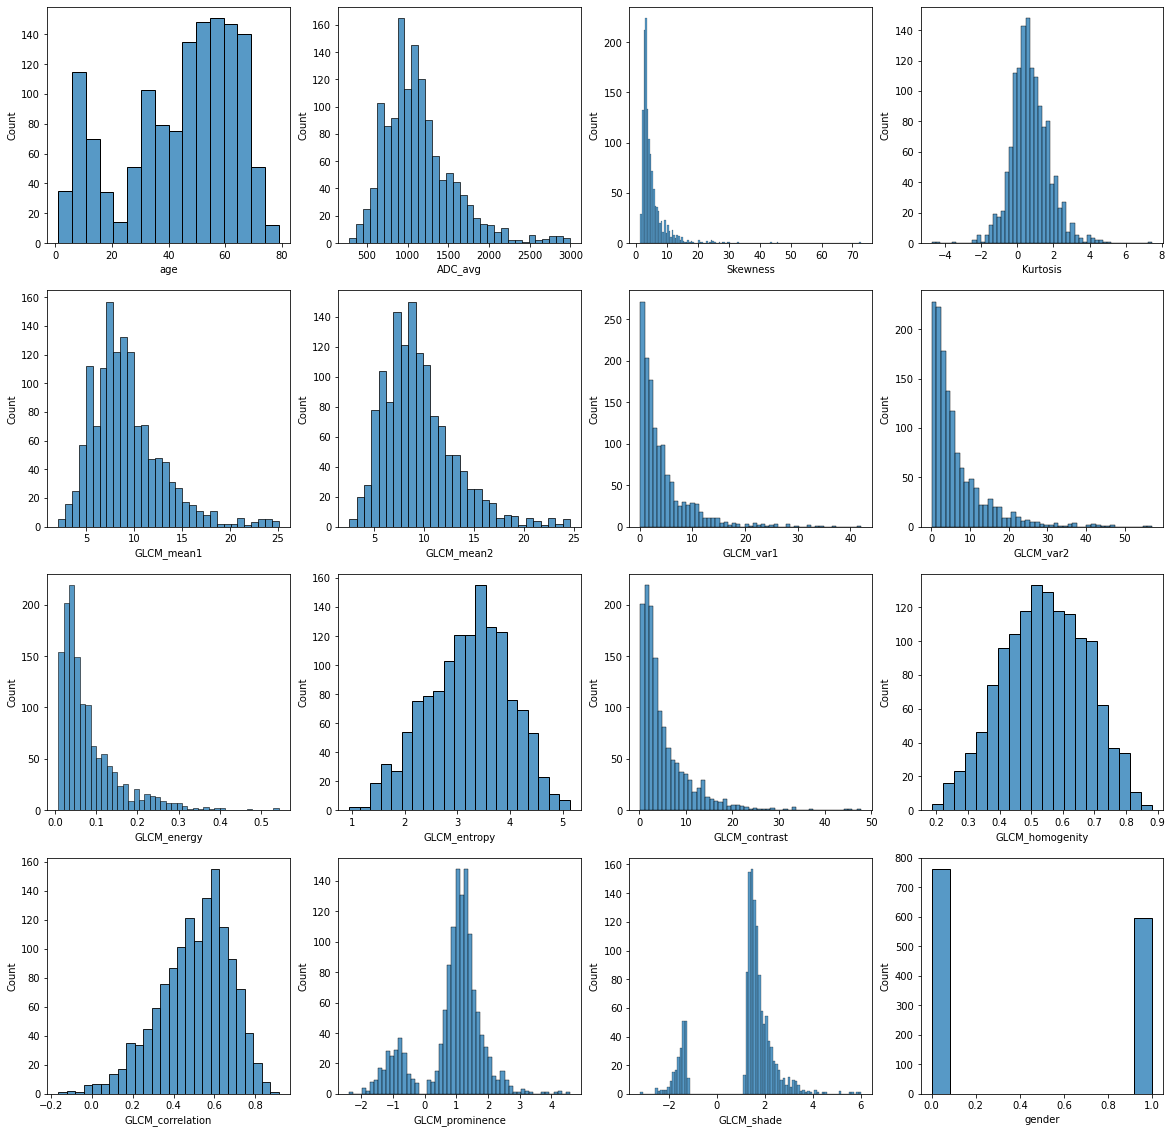

In [6]:
from utils.plot import plot_dataframe_hist

plot_dataframe_hist(df, columns=(NUMERICAL_COLUMNS + CATEGORICAL_COLUMNS), n_cols=4,n_rows=4)

Os histogramas acima permitem justificar as informações obtidas na tabela anterior (obtida através da função `describe()`). É possível ainda verificar quais os atributos que podem, ou não, necessitar de transformações, quais os dados do data set que podem estar enviesados e, para o atributo `gender`, verificar a proporção de 0 e 1, ou seja, a proporção de mulheres e homens.  

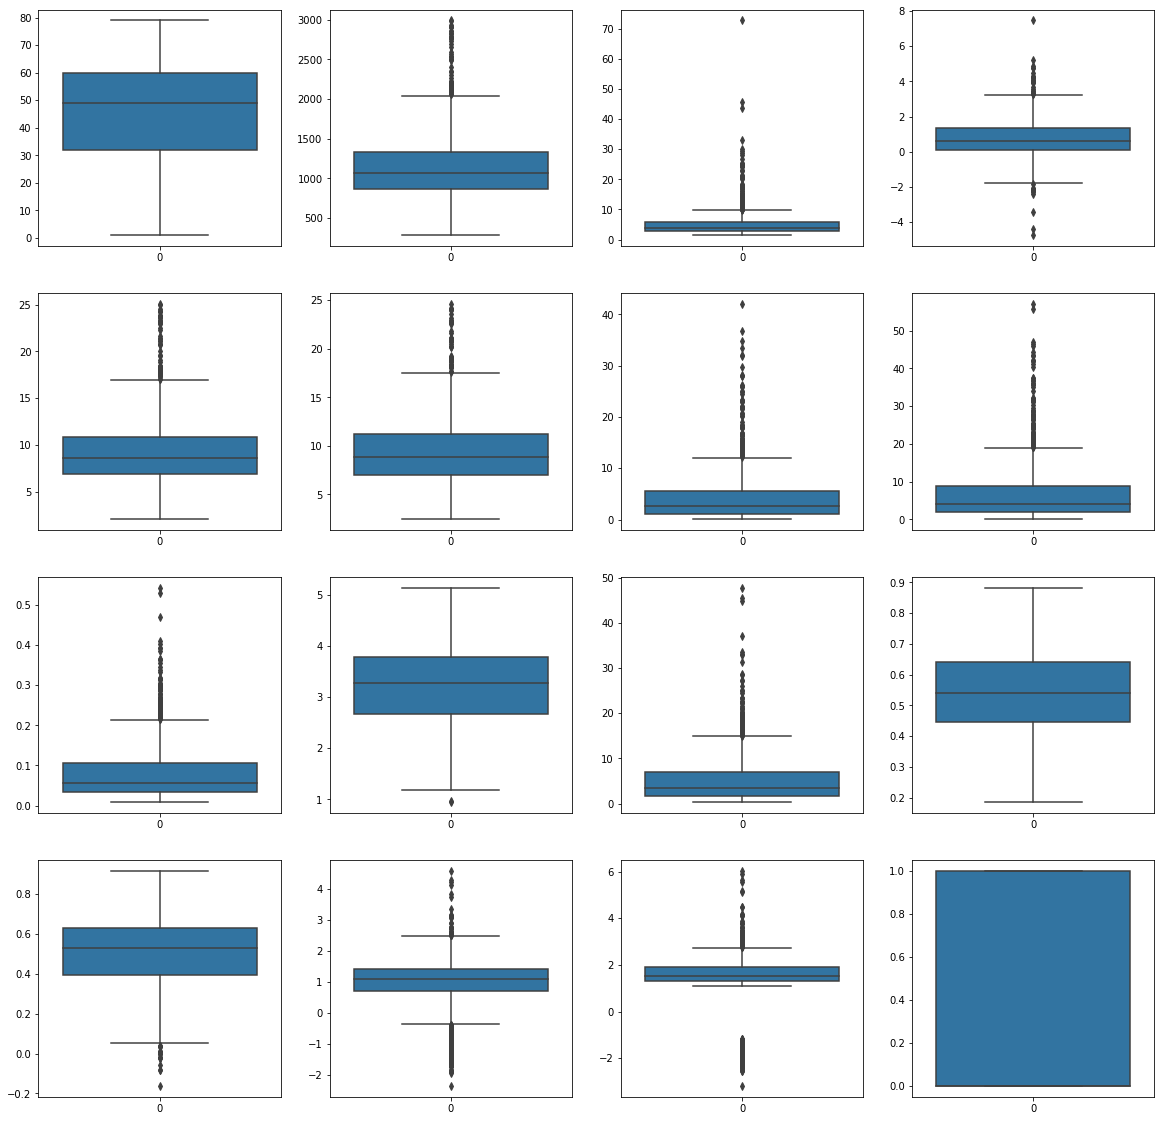

In [7]:
from utils.plot import plot_dataframe_boxplot

plot_dataframe_boxplot(df, columns=(NUMERICAL_COLUMNS + CATEGORICAL_COLUMNS), n_cols=4, n_rows=4)

Recorrendo à utilização de diagramas de caixa, a verificação da existência de _outliers_ e a avaliação da distribuição dos dados tornam-se mais simples.  

Uma forma possível de reduzir o enviesamento e diminuir o número de outliers é transformar os dados através de fórmulas matemáticas. Estas transformações só devem ser aplicados a a atributos que apresentem indícios de enviesamento ou um grande número de _outliers_.

In [8]:
import numpy as np

transformed_df = df.copy()

In [9]:
# com transformações

transformed_df['Skewness'] = np.log(transformed_df['Skewness'])
transformed_df['ADC_avg'] = np.log1p(transformed_df['ADC_avg'])
transformed_df['GLCM_mean1'] = np.log1p(transformed_df['GLCM_mean1'])
transformed_df['GLCM_mean2'] = np.log1p(transformed_df['GLCM_mean2'])
transformed_df['GLCM_var1'] = np.log1p(transformed_df['GLCM_var1'])
transformed_df['GLCM_var2'] = np.log1p(transformed_df['GLCM_var2'])
transformed_df['GLCM_energy'] = np.log1p(transformed_df['GLCM_energy'])
transformed_df['GLCM_contrast'] = np.log1p(transformed_df['GLCM_contrast'])
transformed_df['GLCM_shade'] = - (transformed_df['GLCM_shade']/transformed_df['GLCM_shade'].abs()) * np.log1p(transformed_df['GLCM_shade'].abs())

Após as transformações, ficamos com uma visível redução do número de _outliers_ e do enviesamento dos dados do data set, como podemos ver em baixo:

In [10]:
transformed_df.describe()

age       gender      ADC_avg     Skewness     Kurtosis  \
count  1360.000000  1360.000000  1360.000000  1360.000000  1360.000000   
mean     43.684559     0.438971     6.969085     1.457424     0.728021   
std      19.943512     0.496444     0.363582     0.548806     1.066231   
min       1.000000     0.000000     5.647879     0.382538    -4.750000   
25%      32.000000     0.000000     6.760374     1.071155     0.086000   
50%      49.000000     0.000000     6.968765     1.328797     0.625000   
75%      60.000000     1.000000     7.197386     1.746107     1.348250   
max      79.000000     1.000000     8.004528     4.287208     7.469000   

        GLCM_mean1   GLCM_mean2    GLCM_var1    GLCM_var2  GLCM_energy  \
count  1360.000000  1360.000000  1360.000000  1360.000000  1360.000000   
mean      2.262443     2.292482     1.380599     1.705403     0.076328   
std       0.343241     0.330903     0.749130     0.813697     0.062768   
min       1.127200     1.247894     0.125751     0.139762     0.007968   
25%       2.061500     2.081034     0.761737     1.101274     0.032467   
50%       2.261086     2.287827     1.294864     1.634521     0.054488   
75%       2.476055     2.504076     1.878090     2.279623     0.100750   
max       3.261054     3.243412     3.761898     4.061873     0.433729   

       GLCM_entropy  GLCM_contrast  GLCM_homogenity  GLCM_correlation  \
count   1360.000000    1360.000000      1360.000000       1360.000000   
mean       3.211708       1.567043         0.541414          0.503299   
std        0.778109       0.715949         0.133020          0.174293   
min        0.942000       0.215111         0.185000         -0.163000   
25%        2.665500       1.011055         0.444750          0.394000   
50%        3.272000       1.479329         0.540000          0.527500   
75%        3.783000       2.080407         0.642000          0.628250   
max        5.141000       3.887341         0.883000          0.914000   

       GLCM_prominence   GLCM_shade    diagnosis  
count      1360.000000  1360.000000  1360.000000  
mean          0.884013    -0.682106     0.541912  
std           0.982252     0.752926     0.498424  
min          -2.371000    -1.948193     0.000000  
25%           0.698750    -1.061775     0.000000  
50%           1.089500    -0.931967     1.000000  
75%           1.421000    -0.841890     1.000000  
max           4.584000     1.433416     1.000000

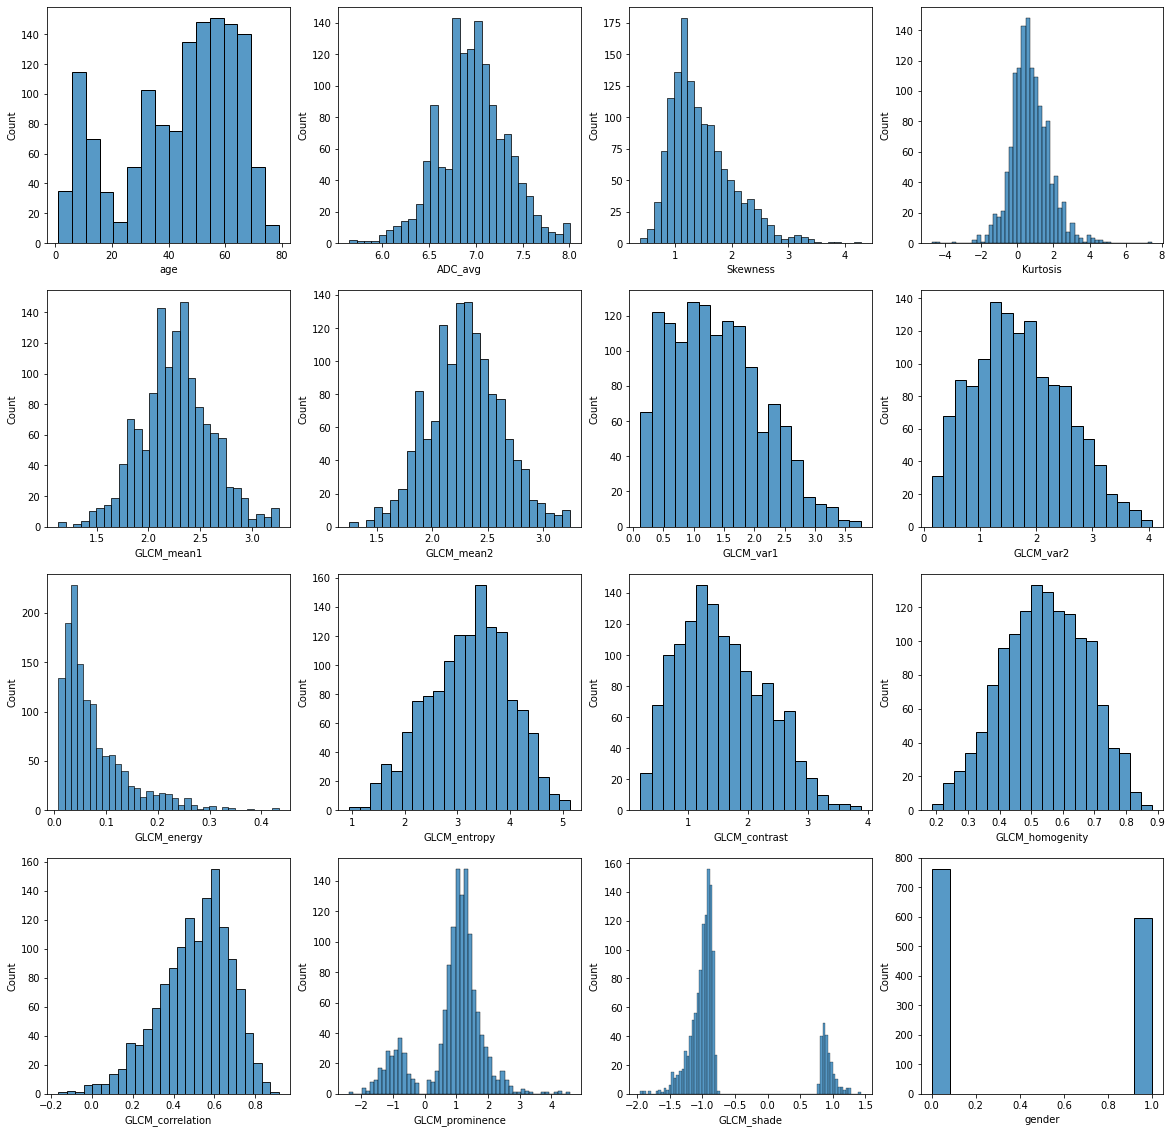

In [11]:
plot_dataframe_hist(transformed_df, columns=(NUMERICAL_COLUMNS + CATEGORICAL_COLUMNS), n_cols=4, n_rows=4)

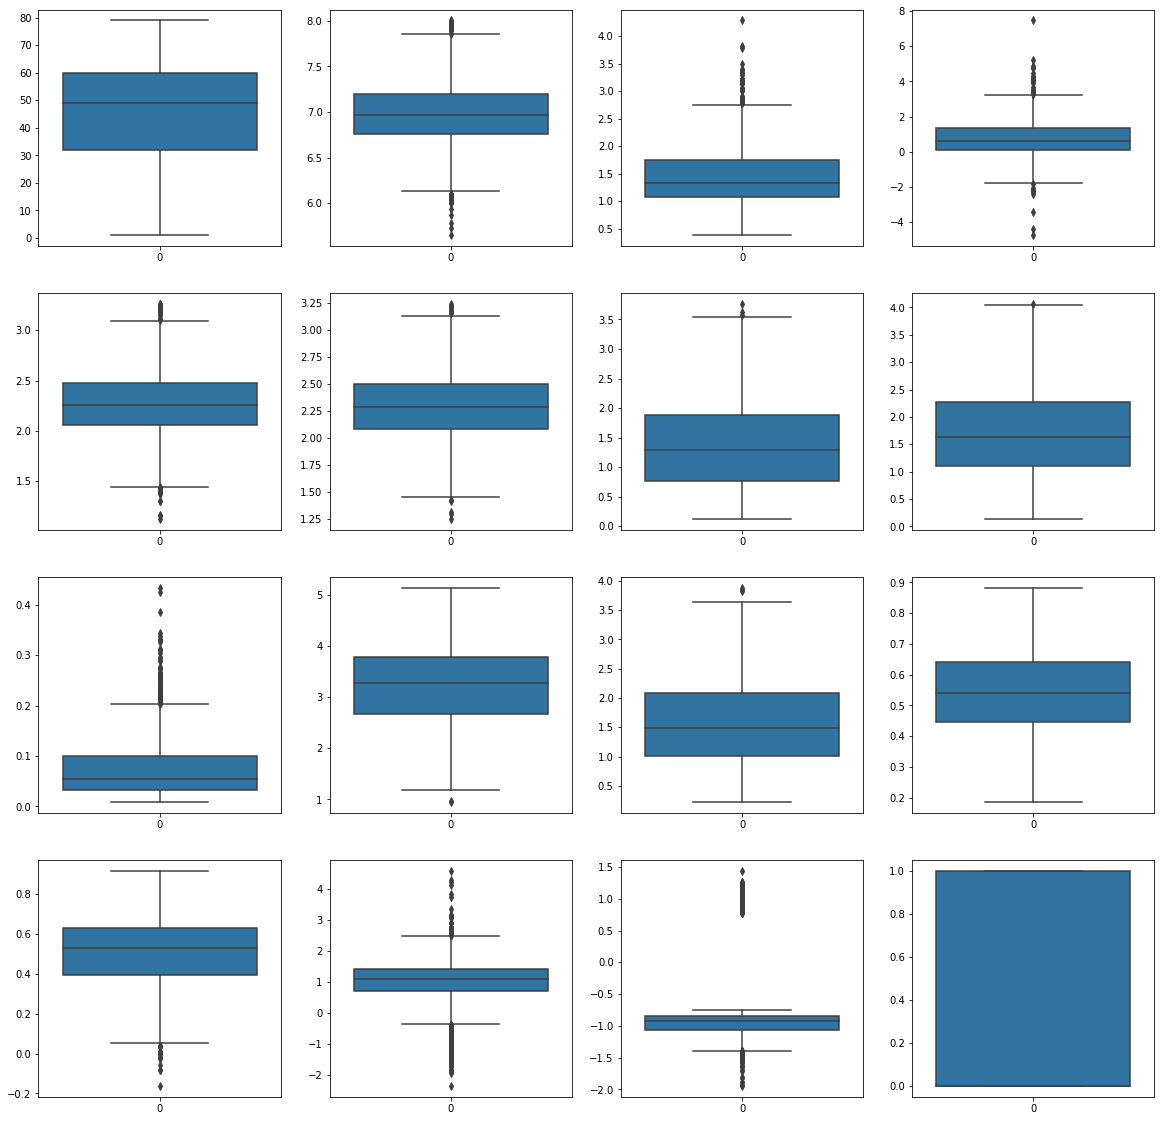

In [12]:
plot_dataframe_boxplot(transformed_df, columns=(NUMERICAL_COLUMNS + CATEGORICAL_COLUMNS), n_cols=4, n_rows=4)

Outro aspeto bastante importante a considerar na construção de um modelo, é sem dúvida, as correlações existentes entre os vários atributos e entre um atributo e o alvo. Esta tarefa torna-se mais fácil através da visualização de _pairplots_ e de _heatmaps_ de correlação.

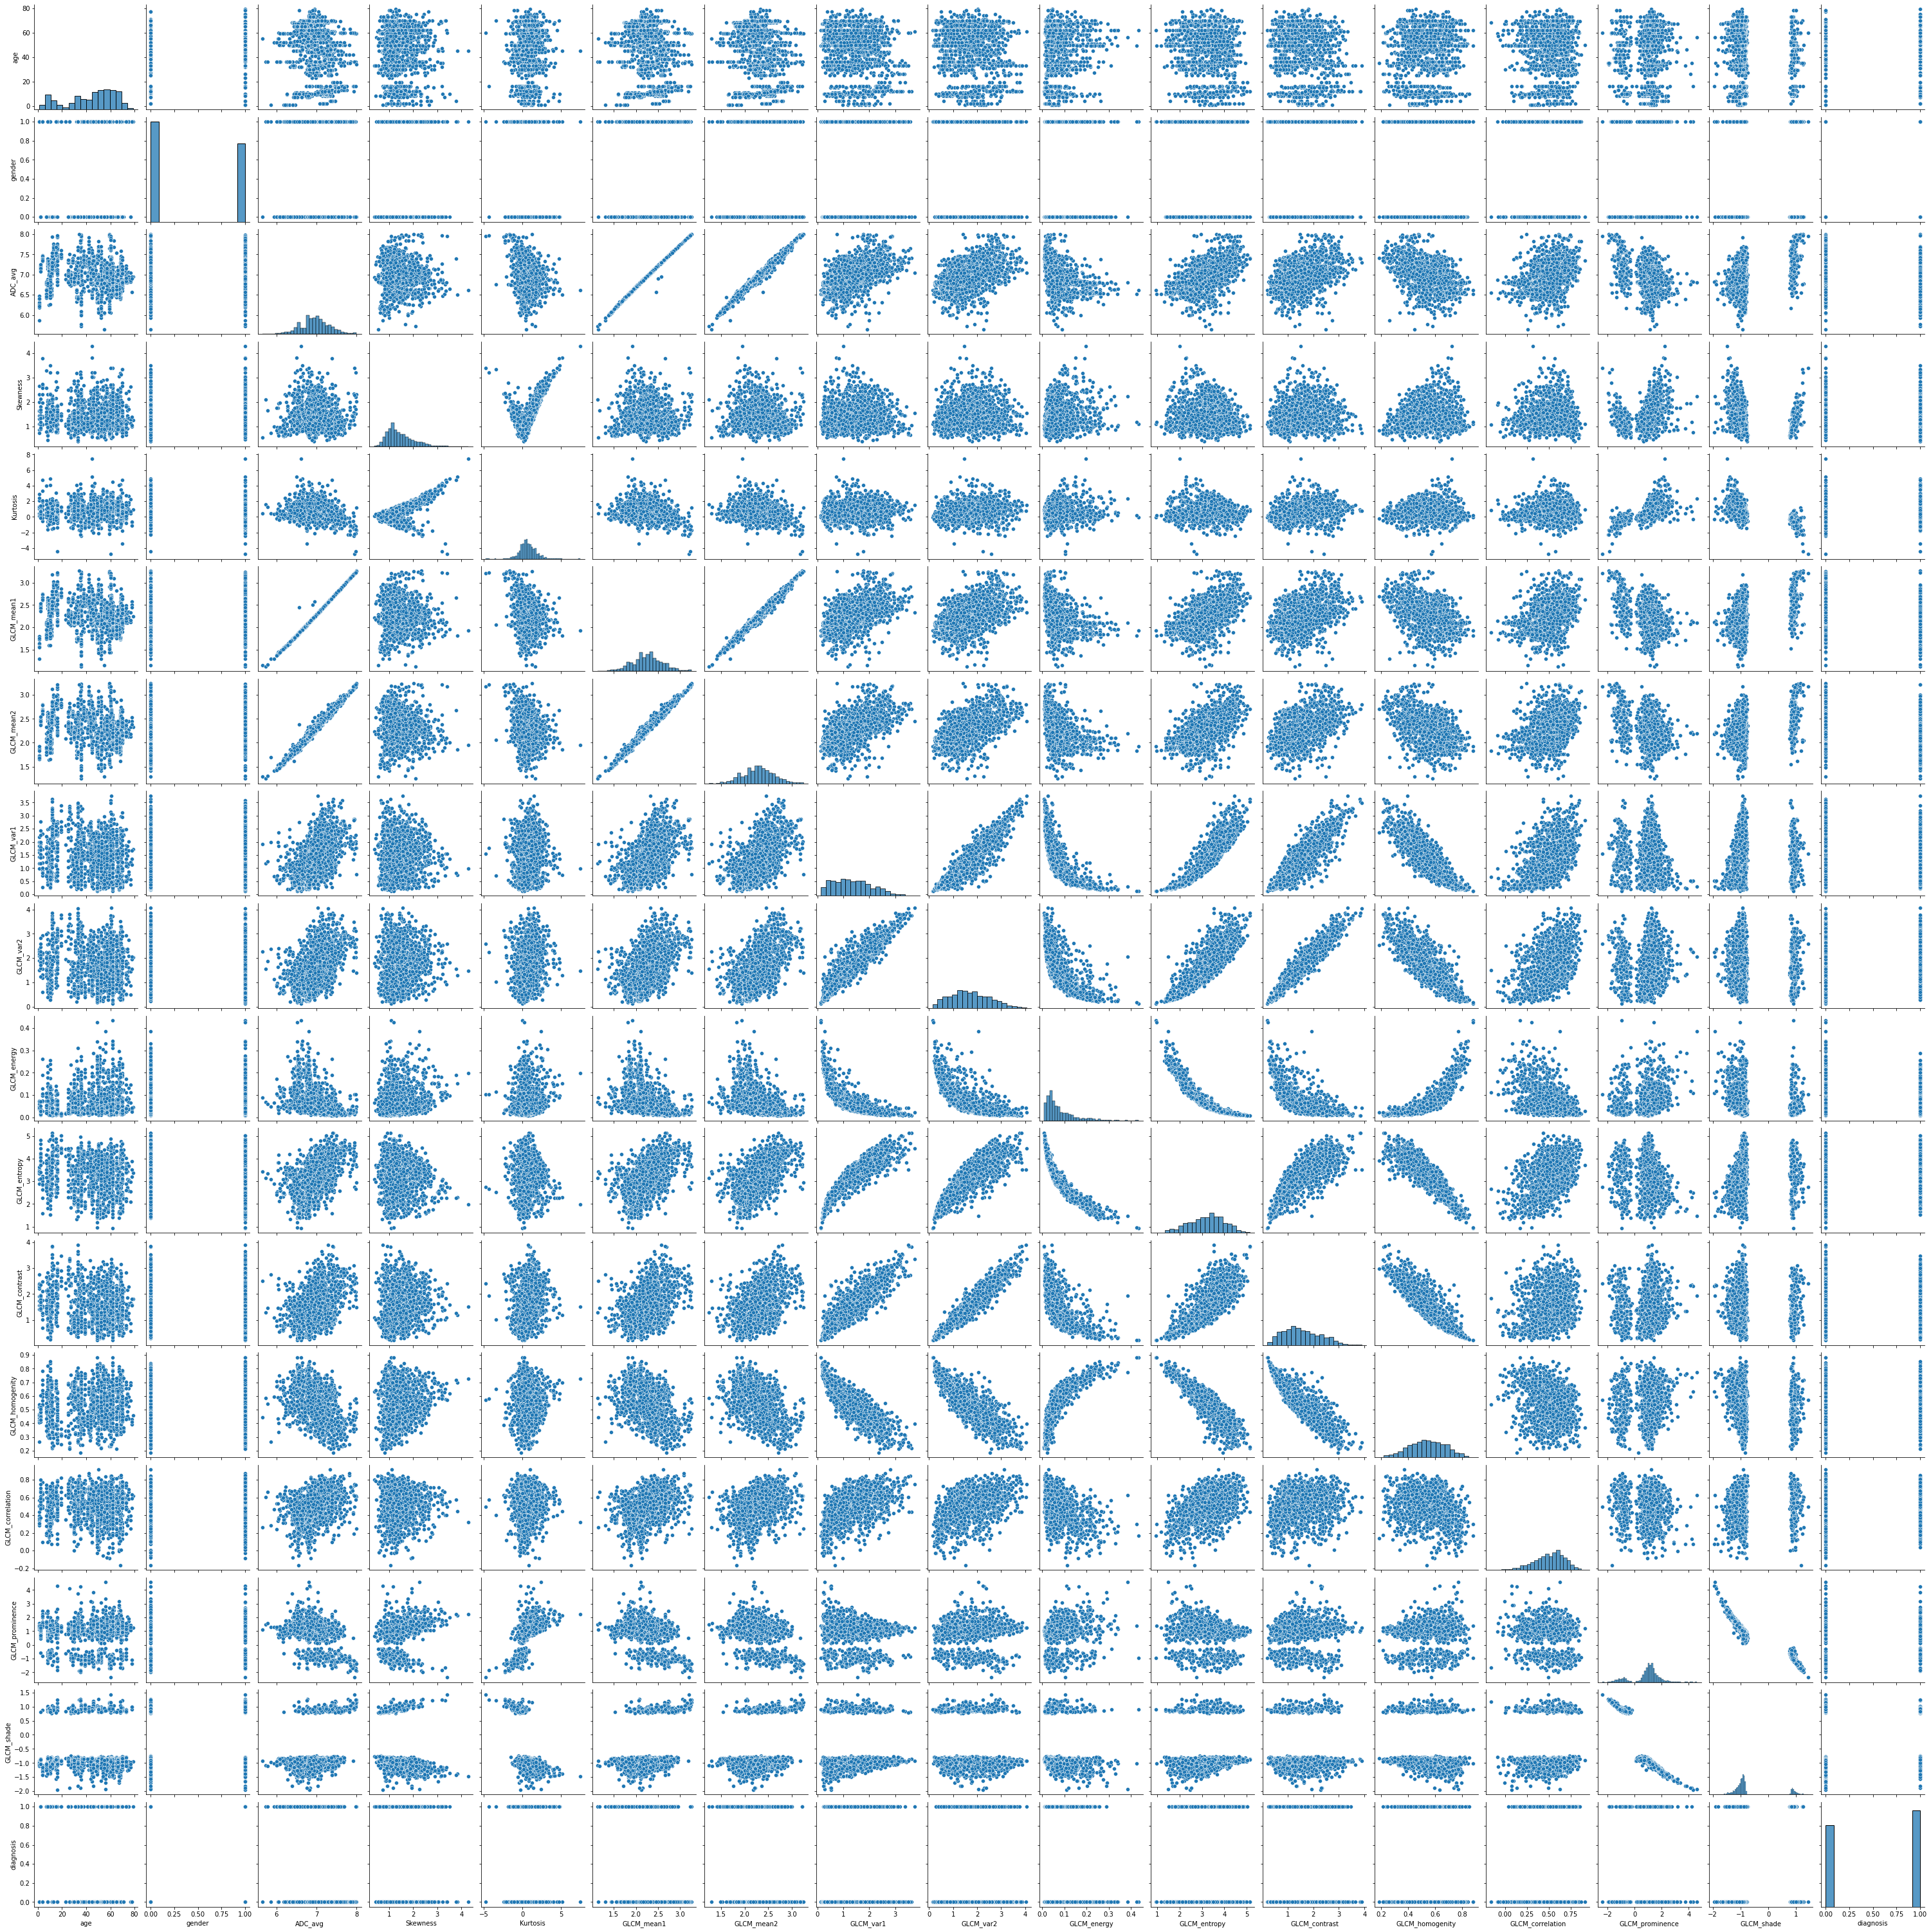

In [13]:
import seaborn as sns

sns.pairplot(transformed_df)

Se existir correlação linear entre dois atributos, o _plot_ associado apresentará uma forma similar a uma reta (com declive positivo, se a correlação for positiva, e com declive negativo, se a correlação for negativa).

<AxesSubplot:>

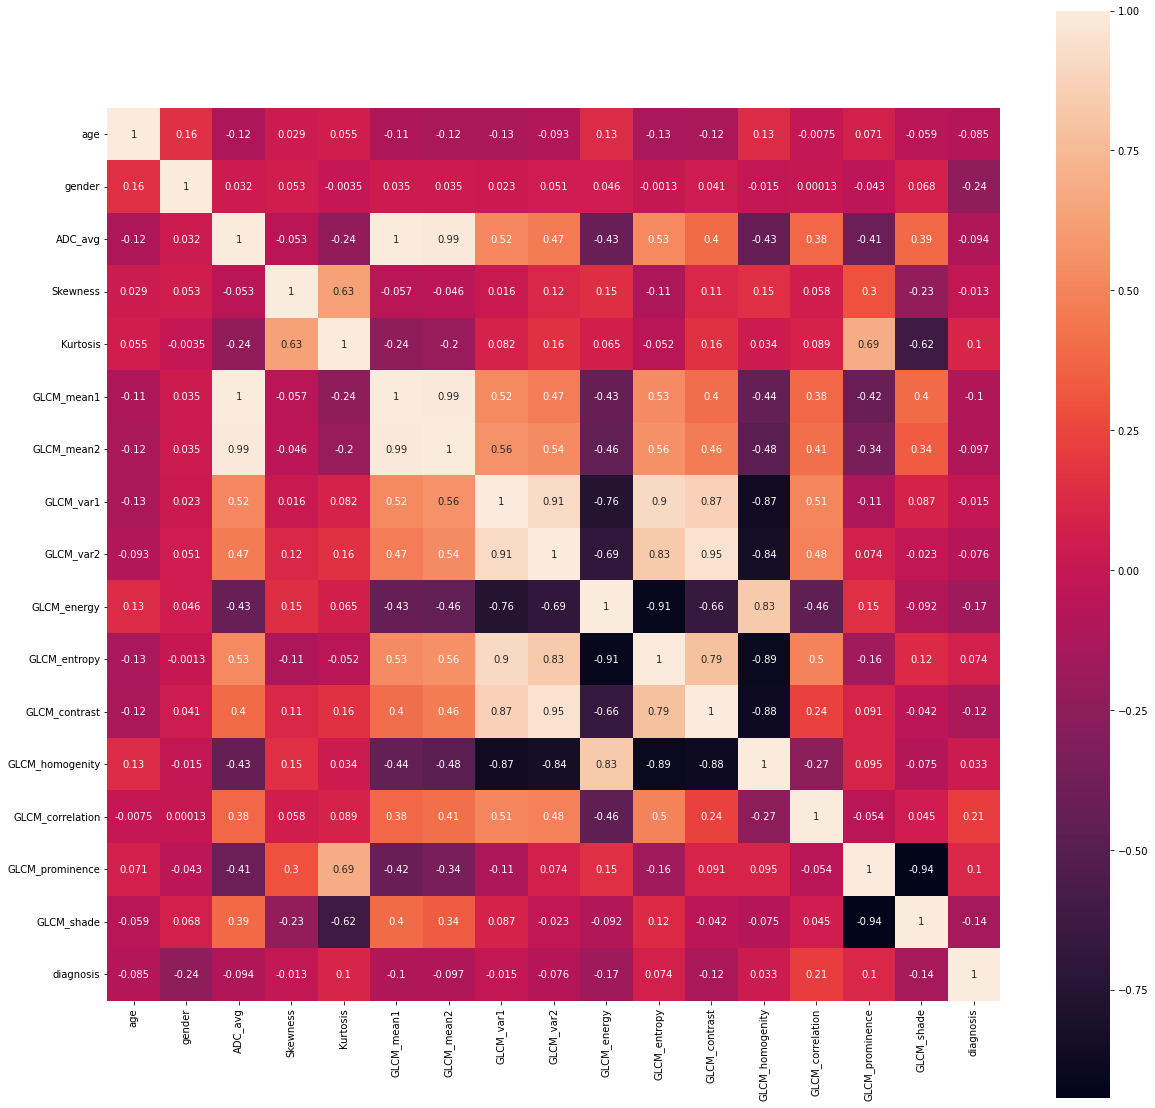

In [14]:
import matplotlib.pyplot as plt

corr = transformed_df.corr()

plt.figure(figsize=(20, 20))

sns.heatmap(corr, annot=corr, square=True)

O _heatmap_ acima permite realçar as correlações verificadas através dos _pairplots_ anteriores. Desta forma é possível identificar se existem propriedades do data set que podem não ser consideradas para a construção do modelo por serem pouco relevantes (o módulo do valor de correlação com o alvo é baixo) ou por dois atributos fornecerem a mesma informação (o módulo do valor da correlação entre os dois é elevado). Esta correlação varia entre -1 e 1.  

Avaliando agora os resultados obtidos podemos tirar várias conclusões, entre elas:  
* o atributo `age` não está correlacionado com nenhum dos outros atributos;
* o atributo `ADC_avg` está correlacionado com os atributos `GLCM_mean1` e `GLCM_mean2`;
* o atributo `GLCM_prominence` está correlacionado com o atributo `GLCM_shade` e apresenta uma correlação com o atributo `Kurtosis` que não é suficientemente forte para se der afirmar que ambos fornecem a mesma informação;
* entre outros...

Em toda esta avaliação, o critério utilizado foi:  
* |valor| > 0.75 ➡ existe uma crrelação suficientemente forte para garantir que a informação apresentada por ambos os atributos é a mesma (ou quase a mesma);
* |valor| <= 0.75 ➡ existe, ou não, uma correlação entre os dois atributos, mas esta não é forte o suficiente para garantir que a informaçã apresentada por ambos é a mesma (ou quase a mesma).

Após todas as conclusões, é possível proceder-se a novos ajustes relativamente a quais os parâmetros considerados para a construção do modelo.

In [15]:
df_corr = transformed_df.copy()

<AxesSubplot:>

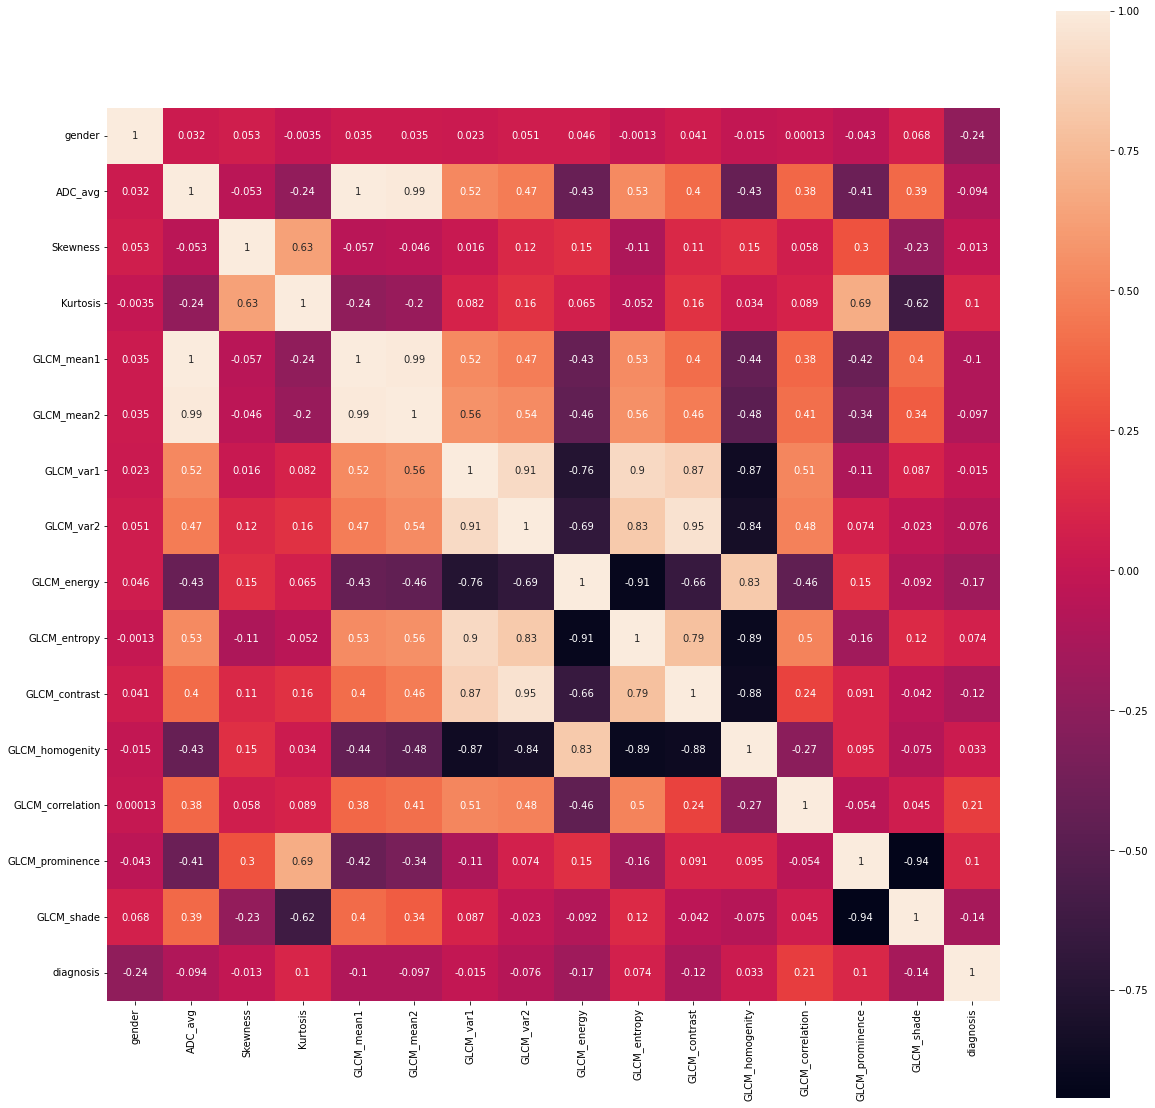

In [16]:
# com novos ajustes
df_corr.drop(COLUMNS_TO_DROP, axis=1, inplace=True)
corr = df_corr.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=corr, square=True)

Neste caso, só a coluna `age` foi descartada.  

É ainda possível proceder-se a uma normalização dos dados numéricos, o que proporciona uma transformação dos dados numa escala semelhante, melhorando o desempenho e a estabilidade do processo de treino do modelo.  

Foram utilizadas vários métodos de normalização:
* `identity`: os valores não são transformados;
* `z_score`: medida numérica que descreve a relação de um valor com a média de um grupo de valores (não é robusto a _outliers_);
* `min_max`: para cada atributo, o valor máximo é transformado em 1, o valor mínimo em 0, e todos os outros em valores decimais etre 0 e 1 (não é robusto a _outliers_);  
* `robust`: remove a mediana e dimensiona os dados de acordo com o intervalo interquartil (é robusto a _outliers_);  
* `quantile`: transforma os dados de modo a que sigam uma distribuição uniforme ou normal (é robusto a _outliers_).

In [17]:
scaled_df = df_corr.copy()

from utils.pre_process import normalize

scaled_df = normalize(df = df_corr, columns=NUMERICAL_COLUMNS_MODEL, normalizer='identity')

scaled_df.describe()

gender      ADC_avg     Skewness     Kurtosis   GLCM_mean1  \
count  1360.000000  1360.000000  1360.000000  1360.000000  1360.000000   
mean      0.438971     6.969085     1.457424     0.728021     2.262443   
std       0.496444     0.363582     0.548806     1.066231     0.343241   
min       0.000000     5.647879     0.382538    -4.750000     1.127200   
25%       0.000000     6.760374     1.071155     0.086000     2.061500   
50%       0.000000     6.968765     1.328797     0.625000     2.261086   
75%       1.000000     7.197386     1.746107     1.348250     2.476055   
max       1.000000     8.004528     4.287208     7.469000     3.261054   

        GLCM_mean2    GLCM_var1    GLCM_var2  GLCM_energy  GLCM_entropy  \
count  1360.000000  1360.000000  1360.000000  1360.000000   1360.000000   
mean      2.292482     1.380599     1.705403     0.076328      3.211708   
std       0.330903     0.749130     0.813697     0.062768      0.778109   
min       1.247894     0.125751     0.139762     0.007968      0.942000   
25%       2.081034     0.761737     1.101274     0.032467      2.665500   
50%       2.287827     1.294864     1.634521     0.054488      3.272000   
75%       2.504076     1.878090     2.279623     0.100750      3.783000   
max       3.243412     3.761898     4.061873     0.433729      5.141000   

       GLCM_contrast  GLCM_homogenity  GLCM_correlation  GLCM_prominence  \
count    1360.000000      1360.000000       1360.000000      1360.000000   
mean        1.567043         0.541414          0.503299         0.884013   
std         0.715949         0.133020          0.174293         0.982252   
min         0.215111         0.185000         -0.163000        -2.371000   
25%         1.011055         0.444750          0.394000         0.698750   
50%         1.479329         0.540000          0.527500         1.089500   
75%         2.080407         0.642000          0.628250         1.421000   
max         3.887341         0.883000          0.914000         4.584000   

        GLCM_shade    diagnosis  
count  1360.000000  1360.000000  
mean     -0.682106     0.541912  
std       0.752926     0.498424  
min      -1.948193     0.000000  
25%      -1.061775     0.000000  
50%      -0.931967     1.000000  
75%      -0.841890     1.000000  
max       1.433416     1.000000

Após toda a análise já realizada, é também importante distinguir quais as componentes principais que melhoram explicam o data set, reduzindo-os a duas dimensões através da utilização do método estatístico _Principal Component Analysis_ (PCA). É de notar que o resultado da aplicação deste método depende da normalização que os dados do data set sofreram.

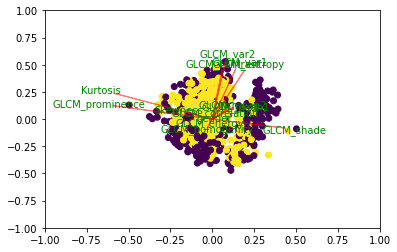

In [18]:
from sklearn.decomposition import PCA
from utils.plot import component_analysis_plot

pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(scaled_df[NUMERICAL_COLUMNS_MODEL + CATEGORICAL_COLUMNS])

component_analysis_plot(reduced[:, 0:2], np.transpose(pca.components_[0:2, :]), NUMERICAL_COLUMNS_MODEL + CATEGORICAL_COLUMNS, scaled_df[TARGET_COLUMN])

plt.show()

Neste caso temos duas componentes distintas, uma formada pelo `ADV_avg` e outra formada pelas restantes variáveis.  

Pode ainda ser verificada a dispersão das _samples_ por classes através do seguinte gráfico:  

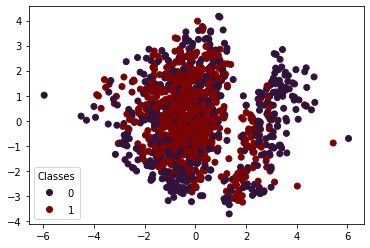

In [19]:
from utils.plot import plot_cluster

plot_cluster(reduced, colors=scaled_df[TARGET_COLUMN])

Com toda esta análise, estamos pronto para começar a pensar no modelo a criar e quais os parâmetros a utilizar pelo mesmo.

## Escolha do Algoritmo

Para a escolha do modelo ideal, é necessário distinguir o que são dados para treinar e o que são as classes dos dados a treinar:
* X ➡ conjunto dos dados de treino;
* Y ➡ classes dos dados de treino.

In [20]:
X, Y = scaled_df[NUMERICAL_COLUMNS_MODEL + CATEGORICAL_COLUMNS], scaled_df[TARGET_COLUMN]

In [21]:
# Classificador K-Nearest Neighbors

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

In [22]:
# Classificador

from sklearn.svm import SVC

svc = SVC(random_state=42)

In [23]:
# Classificador Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

Após escolhidos os algoritmos a serem utilizados para a criação do modelo, é necessário encontrar os melhores parâmetros para os mesmos. Para isso, é comum recorrer-se a métodos de otimização, tal como _Randomized Search_, _Grid Search_ e até mesmo o famoso _BOHB_. Neste trabalho, o utilizado será o _Randomized Search_. 

In [24]:
from sklearn.model_selection import RandomizedSearchCV

In [25]:
# KNN

n_neighbors = [1, 3, 5, 10, 20, 50]

knn_hyper_params = dict(n_neighbors=n_neighbors)

knn_ran_search = RandomizedSearchCV(knn, knn_hyper_params, cv=3, verbose=1, random_state=42, n_iter=6, scoring='f1', n_jobs=-1)

knn_results = knn_ran_search.fit(X, Y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [26]:
# SVC

kernel = ['linear', 'poly', 'rbf', 'sigmoid']

svc_hyper_params = dict(kernel=kernel)

svc_ran_search = RandomizedSearchCV(svc, svc_hyper_params, cv=3, verbose=1, random_state=42, n_iter=4, scoring='f1', n_jobs=-1)

svc_results = svc_ran_search.fit(X, Y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [27]:
# RF

n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30, 50, 100]
min_samples_split = [2, 5, 10, 15, 100, 200]
min_samples_leaf = [1, 2, 5, 10, 20, 30, 50, 100]

rf_hyper_params = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf = min_samples_leaf)


rf_ran_search = RandomizedSearchCV(rf, rf_hyper_params, cv=3, verbose=1, random_state=42, n_iter=300, scoring='f1', n_jobs=-1)

rf_results = rf_ran_search.fit(X, Y)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


Para o cálculo dos _scores_, foi utilizado o **_score F1_**, que transmite o equilíbrio entre a precisão e o _recall_.  

Os melhores parâmetros para os três classificadores são:  

In [28]:
knn_results.best_params_

{'n_neighbors': 20}

In [29]:
svc_results.best_params_

{'kernel': 'poly'}

In [30]:
rf_results.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 5}

## Construção do Modelo

In [31]:
from sklearn.model_selection import cross_validate

**_Cross validation_** é uma técnica utilizada para avaliar a capacidade de generaização de um modelo, a partir de um conjunto de dados. Devido a isso, será utilizada para testar os algoritmos parametrizados. Aqui, o _score F1_ também será utilizado.

In [32]:
knn_new = KNeighborsClassifier(n_neighbors=10)

knn_scores = cross_validate(knn_new, X, Y, cv=3, scoring='f1', return_train_score=True)

In [33]:
svc_new = SVC()

svc_scores = cross_validate(svc_new, X, Y, cv=3, scoring='f1', return_train_score=True)

In [34]:
rf_new = RandomForestClassifier(random_state=42, n_estimators=500, min_samples_split=10, min_samples_leaf=3, criterion='entropy', max_depth=30, n_jobs=-1)

rf_scores = cross_validate(rf_new, X, Y, cv=3, scoring='f1', return_train_score=True)

In [35]:
print("[KNN - TRAIN] %0.2f accuracy with a standard deviation of %0.2f" % (knn_scores['train_score'].mean(), knn_scores['train_score'].std()))
print("[KNN - TEST ] %0.2f accuracy with a standard deviation of %0.2f" % (knn_scores['test_score'].mean(), knn_scores['test_score'].std()))

print("[SVC - TRAIN] %0.2f accuracy with a standard deviation of %0.2f" % (svc_scores['train_score'].mean(), svc_scores['train_score'].std()))
print("[SVC - TEST ] %0.2f accuracy with a standard deviation of %0.2f" % (svc_scores['test_score'].mean(), svc_scores['test_score'].std()))

print("[ RF - TRAIN] %0.2f accuracy with a standard deviation of %0.2f" % (rf_scores['train_score'].mean(), rf_scores['train_score'].std()))
print("[ RF - TEST ] %0.2f accuracy with a standard deviation of %0.2f" % (rf_scores['test_score'].mean(), rf_scores['test_score'].std()))

[KNN - TRAIN] 0.82 accuracy with a standard deviation of 0.01
[KNN - TEST ] 0.69 accuracy with a standard deviation of 0.01
[SVC - TRAIN] 0.78 accuracy with a standard deviation of 0.01
[SVC - TEST ] 0.71 accuracy with a standard deviation of 0.01
[ RF - TRAIN] 0.96 accuracy with a standard deviation of 0.00
[ RF - TEST ] 0.70 accuracy with a standard deviation of 0.03


In [36]:
from sklearn.metrics import f1_score

In [37]:
knn_new.fit(X, Y)
knn_outputs = knn_new.predict(X)
knn_f1 = f1_score(Y, knn_outputs)

svc_new.fit(X, Y)
svc_outputs = svc_new.predict(X)
svc_f1 = f1_score(Y, svc_outputs)

rf_new.fit(X, Y)
rf_outputs = rf_new.predict(X)
rf_f1 = f1_score(Y, rf_outputs)

In [38]:
print('[KNN]', knn_f1)
print('[SVC]', svc_f1)
print(' [RF]', rf_f1)

[KNN] 0.8179986568166556
[SVC] 0.7797878976918278
 [RF] 0.9624664879356568


## Fase de Testes ao Modelo

In [39]:
from utils.post_process import convert_to_numeric

In [40]:
test_df_original = pd.read_csv(DATA_PATH.joinpath('test.csv'))

test_df = test_df_original.copy()

In [41]:
test_df.drop(COLUMNS_TO_IGNORE, axis=1, inplace=True)

test_df = encode_categorical(test_df, columns=CATEGORICAL_COLUMNS)

In [42]:
# aplicar transformações

test_df['Skewness'] = np.log(test_df['Skewness'])
test_df['ADC_avg'] = np.log1p(test_df['ADC_avg'])
test_df['GLCM_mean1'] = np.log1p(test_df['GLCM_mean1'])
test_df['GLCM_mean2'] = np.log1p(test_df['GLCM_mean2'])
test_df['GLCM_var1'] = np.log1p(test_df['GLCM_var1'])
test_df['GLCM_var2'] = np.log1p(test_df['GLCM_var2'])
test_df['GLCM_energy'] = np.log1p(test_df['GLCM_energy'])
test_df['GLCM_contrast'] = np.log1p(test_df['GLCM_contrast'])
test_df['GLCM_shade'] = - (test_df['GLCM_shade']/test_df['GLCM_shade'].abs()) * np.log1p(test_df['GLCM_shade'].abs())


In [43]:
# remover colunas

test_df.drop(COLUMNS_TO_DROP, axis=1, inplace=True)

In [44]:
test_X = test_df[NUMERICAL_COLUMNS_MODEL + CATEGORICAL_COLUMNS]

In [45]:
# KNN

knn_predictions = knn_new.predict(test_X)

knn_test_df = test_df.copy()
knn_test_df[TARGET_COLUMN] = knn_predictions
knn_test_df['id'] = test_df_original['id']

knn_result_set = np.ceil(knn_test_df.groupby(['id'])[TARGET_COLUMN].mean().reset_index())

export_file_name = 'knn'

df_to_export = convert_to_numeric(knn_result_set, ['id', 'diagnosis'])
df_to_export.to_csv(('result_models/' + export_file_name + '.csv'), index=False)

In [46]:
# SVC

svc_predictions = svc_new.predict(test_X)

svc_test_df = test_df.copy()
svc_test_df[TARGET_COLUMN] = svc_predictions
svc_test_df['id'] = test_df_original['id']

svc_result_set = np.ceil(svc_test_df.groupby(['id'])[TARGET_COLUMN].mean().reset_index())

export_file_name = 'svc'

df_to_export = convert_to_numeric(svc_result_set, ['id', 'diagnosis'])
df_to_export.to_csv(('result_models/' + export_file_name + '.csv'), index=False)

In [47]:
# Random Forest

rf_predictions = rf_new.predict(test_X)

rf_test_df = test_df.copy()
rf_test_df[TARGET_COLUMN] = rf_predictions
rf_test_df['id'] = test_df_original['id']

rf_result_set = np.ceil(rf_test_df.groupby(['id'])[TARGET_COLUMN].mean().reset_index())

export_file_name = 'random_forest'

df_to_export = convert_to_numeric(rf_result_set, ['id', 'diagnosis'])
df_to_export.to_csv(('result_models/' + export_file_name + '.csv'), index=False)

Os ficheiros gerados encontram-se na pasta `result_models/` e os três ficheiros finais encontram-se na pasta `models/`.

## Três Modelos

Após o término da competição no _Kaggle_, uma nova classificação (a classificação privada), foi disponibilizada e os resultados foram os seguintes:

##### Classificação Pública

* **Classificador:** `sklearn.ensemble.RandomForestClassifier`;
* **Parâmetros:**  
    * **random_state:** 42;
    * **n_estimators:** 500;
    * **min_samples_split:** 10;
    * **min_samples:leaf:** 3;
    * **criterion:** entropy;
    * **max_depth:** 30;
    * **n_jobs:** -1;
* **Colunas não consideradas:** *id*, *slice_loc* e *age*;
* **Transformações:** N/A;
* **Tipo de Normalização:** identity;
* **Score Público:** 0.69565;
* **Score Privado:** 0.73333;
* **Score Final:** 0,706954.

##### Classificação Privada

* **Classificador:** `sklearn.neighbors.KNeighborsClassifier`;
* **Parâmetros:**  
    * **n:** 10;
* **Colunas não consideradas:** *id*;
* **Transformações:** N/A;
* **Tipo de Normalização:** identity;
* **Score Público:** 0.45454;
* **Score Privado:** 0.85714;
* **Score Final:** 0,57532.

##### Modelo Escolhido

* **Classificador:** `sklearn.svm.SVC`;
* **Parâmetros:** N/A;
* **Colunas não consideradas:** *id*;
* **Transformações:** N/A;
* **Tipo de Normalização:** identity;
* **Score Público:** 0.58181;
* **Score Privado:** 0.83870;
* **Score Final:** 0,658877.

Acabou por ser escolhido este modelo por ter sido uilizado outro classficador para o construir, sem quaisquer parâmetros definidos.

O cálculo do _score final_ foi realizado através da fórmula `score_final = score_publico * 0.7 + score_privado * 0.3`.

## Comparação entre os Três Modelos

<h5>KNN.compare(RandomForest)</h5>
<img src="img/knn-rf.png" alt="" width="30%"/>

<h5>RandomForest.compare(SVC)</h5>
<img src="img/rf-svc.png" alt="" width="30%"/>

<h5>SVC.compare(KNN)</h5>
<img src="img/svc-knn.png" alt="" width="30%"/>



## Conclusão

Ao contrário do que foi pensado inicialmente, este trabalho revelou-se difícil, não só pela diversidade de algoritmos e parâmetros para os mesmos, mas também por todo o processo de análise dos dados que foi necessária e pela dimensão reduzida dos mesmos.  

Foi possível então aprender um pouco mais sobre a tarefa de um programador de modelos para a realização de tarefas através de **aprendizagem automática**, tais como encontrar o melhor algoritmo, compreender quais os atributos menos relevantes para a classificação dos dados, aplicar métodos de _tunning_ de dados, entre outros.  

É também de salientar que, após cada submissão cujo _score_ era inferior ao melhor _score_ anterior, a frustração aumentava e a ideia de que o nosso processo de exploração do data set poderia não estar certo deixava-nos ainda mais desmotivados.  

No final, e quando os _scores_ privados foram disponibilizados, foi possível constatar que, se calhar, a razão para a qual os _scores_ obtidos anteriormente eram tão baixos poderia ser a dimensão reduzida do conjunto de treino.

Este trabalho poderia ainda ter uma outra vertente de exploração caso os dados apresentassem uma relação temporal entre si, para cada identificador. Isto tornaria todo o processo de exploração dos dados ainda mais interessant, existindo a possibilidade de se utilizar outros algritmos.

Em conclusão, é possível afirmar que, encontrar um modelo que consiga classificar todos os exemplos de forma correta não é fácil e, na maioria das vezes, impossível. Isto acontece devido a todos os aspetos que têm de ser considerados para a elaboração do mesmo, tais como atributos irrelevantes para a classifiação, correlações existentes entre os vários atributos do data set, e até mesmo a qualidade dos dados do data set.